In [2]:
from IPython.display import display, HTML 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h1 style="color:red;">DI-725 : Transformers and Attention-Based Deep Networks</h1>
  <h2 style="color:red;">Final Project : Phase - 2</h2>
  <br><br>
  <h4 style="color:red;">Turgay Yıldız</h4>
  <br>
  <h4 style="color:red;">Graduate School of Informatics, Middle East Technical University (METU)</h4>
</div>

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Fetch big_vision code and install dependencies</h3>
</div>

In [3]:
import os
import sys
!pip install evaluate
!pip install rouge_score

In [4]:
# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo 

In [5]:
# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo") 

In [6]:
# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece" 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Model and Pre-trained weights : </h3>
</div>

In [7]:
import os 

In [8]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["..."]       =    '...'
os.environ["..."]       =    '...' 

In [9]:
# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [10]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import kagglehub

In [11]:
# Use these for PaliGemma 1:
LLM_VARIANT   = "gemma_2b"
MODEL_PATH    = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224" 

In [12]:
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

Model path: /kaggle/input/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


In [13]:
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !wget https://storage.googleapis.com/big_vision/paligemma_tokenizer.model -O {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Core Library Imports : </h3>
</div>

In [14]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding


2025-05-13 02:09:23.697354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747102163.907660     883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747102163.967747     883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
##################################################################################################################
#                                   Set seeds for reproducibility
##################################################################################################################
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
jax_rng_key = jax.random.PRNGKey(SEED)  

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Reserve GPU/TPU for JAX </h3>
</div>

In [16]:
# Don't let TF use the GPU or TPUs
# Disables TensorFlow’s access to GPUs/TPUs so JAX can fully utilize them without resource contention.
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend() 
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;">Construct model and load params into RAM </h3>

 <h5 style="color:red;"> model_config: hyperparameters for both the vision encoder and text decoder.
<br>
                          Instantiate the combined Vision+LLM model.
<br>
                          Load pretrained weights into a parameter tree.
<br>
                          Build a decode function for efficient batched generation.
                          </h5>


</div>

In [17]:
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})

In [18]:
model     = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

In [19]:
# Define `decode` function to sample outputs from the model.
decode_fn  =   predict_fns.get_all(model)['decode']
decode     =   functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()) 

In [20]:
PROMPT_LEN  =    10  
old_params  =    paligemma.load(None, MODEL_PATH, model_config)

soft_prompt =    jax.random.normal(                    
                                jax_rng_key,
                                (PROMPT_LEN, 2048),   
                            ).astype(jnp.float32) 

# Add it to your param PyTree so it's updated by JAX:
params = {"soft_prompt": soft_prompt, **old_params} 

In [21]:
    # Create a pytree mask of the trainable params.
    def is_trainable_param(name, param):  # pylint: disable=unused-argument
      if name.startswith("llm/layers/attn/"):  return True
      if name.startswith("soft_prompt"):       return True  
      if name.startswith("llm/"):              return False
      if name.startswith("img/"):              return False
          
      raise ValueError(f"Unexpected param name {name}")
        
    trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)  

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Sharding & Casting Parameters :  </h3>

  <h5 style="color:red;">  Sharding: split tensors across devices (if you had >1 GPU).
<br>
                        maybe_cast_to_f32: keep the frozen weights in fp16 to save memory; cast the few trainable ones to fp32 so their gradients remain stable.
<br>
                        The loop unpacks the parameter tree, reshares & casts each leaf, and reassembles it.
</h5>
</div>


In [22]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

In [23]:
@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Define preprocess functions to create inputs to the model :  </h3>
</div>

In [24]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------# 
#----------------------------------------------------------------------------------------------#
def preprocess_tokens(suffix: str | None, seqlen: int = None,  PROMPT_LEN : int = None): 
    """
    Tokenize only the suffix (caption) and build masks,
    leaving room for PROMPT_LEN soft‐prompt embeddings.

    Returns:
      tokens      : np.int32 array of length seqlen (or PROMPT_LEN if no suffix)
      mask_ar     : np.int32 array, 0=full attention (for prefix), 1=causal (for suffix)
      mask_loss   : np.int32 array, 0=no loss on prefix, 1=loss on suffix
      mask_input  : np.int32 array, 1=real token, 0=padding
    """
    # 1) Tokenize suffix if given
    if suffix is not None:
        # separator token
        sep_ids = tokenizer.encode("\n", add_bos=False, add_eos=False)
        suf_ids = tokenizer.encode(suffix, add_bos=False, add_eos=True)
        
        tokens_suf    = sep_ids + suf_ids
        mask_ar_suf   = [1] * len(tokens_suf)
        mask_loss_suf = [1] * len(tokens_suf)
    else:
        tokens_suf    = []
        mask_ar_suf   = []
        mask_loss_suf = []

    # 2) Build the combined sequence
    #    Prefix (soft prompts) occupy positions [0..PROMPT_LEN-1], so we
    #    start our discrete IDs at index PROMPT_LEN.
    tokens     = [0] * PROMPT_LEN  + tokens_suf
    mask_ar    = [0] * PROMPT_LEN  + mask_ar_suf
    mask_loss  = [0] * PROMPT_LEN  + mask_loss_suf
    mask_input = [0] * PROMPT_LEN  + [1] * len(tokens_suf)

    # 3) Pad/truncate to seqlen if requested
    if seqlen is not None:
        length = len(tokens)
        if length < seqlen:
            pad_len = seqlen - length
            tokens     += [0] * pad_len
            mask_ar    += [0] * pad_len
            mask_loss  += [0] * pad_len
            mask_input += [0] * pad_len
        else:
            tokens     = tokens[:seqlen]
            mask_ar    = mask_ar[:seqlen]
            mask_loss  = mask_loss[:seqlen]
            mask_input = mask_input[:seqlen]

    # 4) Return as arrays
    return (
        np.array(tokens,     dtype=np.int32),
        np.array(mask_ar,    dtype=np.int32),
        np.array(mask_loss,  dtype=np.int32),
        np.array(mask_input, dtype=np.int32),
    )
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------#
def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Import Data  :  </h3>
</div>

In [25]:
import tensorflow as tf
import pandas as pd 

In [26]:
captions_df = pd.read_csv('/kaggle/input/rsics-dataset/captions.csv') 
print(captions_df.head()) 

  source split           image  \
0   NWPU  test  NWPU_31430.jpg   
1   NWPU  test  NWPU_31431.jpg   
2   NWPU  test  NWPU_31432.jpg   
3   NWPU  test  NWPU_31433.jpg   
4   NWPU  test  NWPU_31434.jpg   

                                           caption_1  \
0   A gray plane on the runway and the lawn beside .   
1  Three small planes parked in a line on the air...   
2  A plane parked in a line on the airport with s...   
3  A small plane and a big plane parked next to b...   
4       Two planes parked next to boarding bridges .   

                                           caption_2  \
0        A grey plane is on the runway by the lawn .   
1  There are four aircraft on the open ground, Th...   
2  A white plane was parked on the instruction li...   
3  A white plane and a gray plane parked at the b...   
4  Two aircraft were parked at the departure gates .   

                                           caption_3  \
0  There is an airplane on the runway with a larg...   
1  There 

In [27]:

IMAGE_ROOT = "/kaggle/input/rsics-dataset/resized" 
BATCH_SIZE = 32
IMG_SIZE   = (224, 224) 

In [28]:
print("All split labels:", captions_df['split'].unique())
print("Counts:\n", captions_df['split'].value_counts()) 

All split labels: ['test' 'val' 'train']
Counts:
 split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [29]:
# 4. Filter into splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = captions_df[captions_df['split'] == split_name] 

In [30]:
# 5. Convert each split-DataFrame into (paths, captions)
def df_to_paths_and_captions(split_df):
    # Full paths
    paths = split_df['image'].apply(lambda fn: os.path.join(IMAGE_ROOT, fn)).tolist()
    # List-of-captions per example
    captions_cols = [f'caption_{i}' for i in range(1,6)]
    captions = split_df[captions_cols].values.tolist()
    return paths, captions 

In [31]:
len(splits['val'])

4453

In [32]:
train_paths, train_caps = df_to_paths_and_captions(splits['train']) 
val_paths,   val_caps   = df_to_paths_and_captions(splits['val']) 
test_paths,  test_caps  = df_to_paths_and_captions(splits['test']) 

In [33]:
len(val_paths)

4453

In [34]:
# 6. Preprocessing fn: load image + return captions list
def _load_and_preprocess(path, captions):
    # Read & decode
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize & normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, captions

# 7. Build the tf.data pipeline
def make_dataset(paths, captions, shuffle=False):
    # turn your Python list-of-strings into a tf.string tensor
    paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(paths, dtype=tf.string))
    # turn your list-of-lists-of-strings into a [5] tf.string tensor
    caps_ds  = tf.data.Dataset.from_tensor_slices(tf.constant(captions, dtype=tf.string))

    ds = tf.data.Dataset.zip((paths_ds, caps_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ( ds
           .map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE) 
         )
    return ds

In [35]:
train_ds = make_dataset(train_paths, train_caps, shuffle=True)
val_ds   = make_dataset(val_paths,   val_caps,   shuffle=True) 
test_ds  = make_dataset(test_paths,  test_caps,  shuffle=False) 

In [36]:
def train_data_iterator(PROMPT_LEN, SEQLEN):
    """Never-ending iterator over training examples from train_ds."""
    while True:
        for image_batch, caps_batch in train_ds:
            images_np = image_batch.numpy()      # [B,H,W,3]
            caps_np   = caps_batch.numpy()       # [B,5] bytes

            for img, caps in zip(images_np, caps_np):
                decoded_caps = [c.decode('utf-8') for c in caps]             #  All Captions
                
                rng    = np.random.default_rng(SEED)                         # We can not randomly choose anymore ! 
                suffix = decoded_caps[rng.integers(5)].lower()


                # Prepare tokens and masks
                tokens, mask_ar, mask_loss, mask_in   =  preprocess_tokens( suffix,  SEQLEN,   PROMPT_LEN ) 
                
                img_proc = img * 2.0 - 1.0
                yield [{
                    "image": img_proc,
                    "text": np.asarray(tokens, dtype=np.int32),
                    "mask_ar": np.asarray(mask_ar, dtype=np.int32),
                    "mask_loss": np.asarray(mask_loss, dtype=np.int32),
                    "mask_input": np.asarray(mask_in,  dtype=np.int32),  # ← Add this
                }, decoded_caps] 

def validation_data_iterator(PROMPT_LEN, SEQLEN): 
    """Single-pass iterator over validation examples from val_ds."""
    
    for image_batch, caps_batch in val_ds:
        
        images_np = image_batch.numpy()
        caps_np   = caps_batch.numpy()

        for img, caps in zip(images_np, caps_np):
            decoded_caps = [c.decode('utf-8') for c in caps]       #  All Captions 

            # Prepare tokens and masks
            tokens, mask_ar, mask_loss, mask_in   =  preprocess_tokens( None,  SEQLEN,  PROMPT_LEN)    # suffix = None 
            
            img_proc = img * 2. - 1.
            yield [{
                "image": img_proc,
                "text": np.asarray(tokens, dtype=np.int32),
                "mask_input": np.asarray(mask_in, dtype=np.int32),
                "mask_ar": np.asarray(mask_ar, dtype=np.int32), 
            }, decoded_caps]


In [ ]:
# 8. Quick sanity check
for imgs, caps in test_ds.take(1):
    print("Images batch shape:", imgs.shape)            # (BATCH_SIZE, H, W, 3)
    print("Captions batch shape:", len(caps), "examples")
    print("First example captions:", caps[0])            # a list of 5 strings 

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Evaluation / Inference Loop :  </h3>
</div>

In [37]:
SEQLEN  =  128 

In [38]:
# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    captions = [] 
    try:
      for _ in range(batch_size):

        example, caps = next(data_iterator) 
        example["_mask"]   = np.array(True)
        example["caption"] = caps
        
        # Keep the caption aside
        caption = example.pop("caption") 
        captions.append(caption)
        
        examples.append(example)


    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    #batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response, caption in zip(examples, responses, captions):
        outputs.append((example["image"], response, caption))
   
        if num_examples and len(outputs) >= num_examples:
            return outputs

In [ ]:
it   =   validation_data_iterator(10, 32) 

In [ ]:
out  =  make_predictions(it, num_examples=8,
                                 batch_size=8, seqlen=32) 

In [ ]:
out[num][2]

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> WANDB :  </h3>
</div>

In [39]:
import wandb 

In [40]:
os.environ["..."]       = "..."   

In [41]:
wandb.login()  

wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725___Final_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Hyper-Parameter Tuning & Ablation Study :  </h3>
</div>

In [42]:
import io, base64
from PIL import Image 

import pickle
import evaluate
import tqdm

import torch


In [43]:
##################################################################################################################
#                                         Install & load metrics                                                 #                       
##################################################################################################################
from evaluate import load as load_metric
bleu_metric   = evaluate.load("bleu")
rouge_metric  = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor") 

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [44]:
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

In [45]:
def train(config=None):  

##################################################################################################################
#                                   Initialize params
##################################################################################################################
    PROMPT_LEN  =    10  
    old_params  =    paligemma.load(None, MODEL_PATH, model_config)

    soft_prompt =    jax.random.normal(                    # since this is deleted after training, we need to define it each time (sweep). 
                                    jax_rng_key,
                                    (PROMPT_LEN, 2048),   
                                ).astype(jnp.float32) 
    
    # Add it to your param PyTree so it's updated by JAX:
    params = {"soft_prompt": soft_prompt, **old_params} 

##################################################################################################################
#                                   Initialize a new wandb run
##################################################################################################################
    
    with wandb.init(config=config): 
    
##################################################################################################################
#                                                  read config                                                   #
##################################################################################################################        
        cfg   =    wandb.config 
    
##################################################################################################################    
#                                        Unpack hyper-parameters & flags                                         #                     
##################################################################################################################
        BATCH_SIZE     =   cfg.batch_size
        LEARNING_RATE  =   cfg.learning_rate
        SEQLEN         =   cfg.seqlen 
        
        TRAIN_STEPS    = 201  
        TRAIN_EXAMPLES = TRAIN_STEPS * BATCH_SIZE 
        eval_steps     = 100  
##################################################################################################################   
#                                              Training loop                                                     # 
##################################################################################################################

        train_it     = train_data_iterator(PROMPT_LEN, SEQLEN)    
    
        sched_fn = big_vision.utils.create_learning_rate_schedule( 
            total_steps=TRAIN_STEPS+1,
            base=LEARNING_RATE,
            decay_type=cfg.lr_decay,
            warmup_percent=cfg.warmup_percent,
        )
        
        for step in range(1, TRAIN_STEPS + 1): 
    
            examples = [next(train_it)[0] for _ in range(BATCH_SIZE)] 
        
            batch    = jax.tree.map(lambda *x: np.stack(x), *examples) 
            #batch    = big_vision.utils.reshard(batch, data_sharding)
        
            lr           = sched_fn(step)
            params, loss = update_fn(params,  batch, lr)   
            loss_val     = float(jax.device_get(loss))
        
            print(f"step: {step}/{TRAIN_STEPS}   lr: {lr:.8f}   loss: {loss_val:.4f}")
            wandb.log({"train/loss": loss_val, "train/lr": lr}, step=step)
            
##################################################################################################################
#                                           Evaluation :                                                         #
##################################################################################################################
            if step % eval_steps == 0: 
                print(f"→ Evaluation at step {step}")
    
                # A) Batch‐collect all validation examples once
                all_examples = []
                all_captions = []
        
                
                # one call, batch_size=TOTAL to run one forward of 8
                demo_outputs = make_predictions(
                                                validation_data_iterator(PROMPT_LEN, SEQLEN),
                                                num_examples=8,
                                                batch_size=8,
                                            )
                
                
                # demo_outputs is a list of (img, pred, ref) of length num_to_eval
                all_hyps = [pred for (_, pred, _) in demo_outputs]
                all_refs = [[ref] for (_, _, ref) in demo_outputs] 
    
##################################################################################################################
#                                          compute & log BLEU/ROUGE/METEOR                                       # 
##################################################################################################################
                # 1) Filter out any fully empty predictions
                # Filter out any empty predictions, just in case
                filtered = [(h, refs) for h, refs in zip(all_hyps, all_refs) if h.strip()]
                if filtered:
                    all_hyps, all_refs = zip(*filtered)
                    all_hyps, all_refs = list(all_hyps), list(all_refs)
                else:
                    all_hyps, all_refs = [], []
        
                # Only call metrics if we have at least one example
                if all_hyps:
                    bleu_res = bleu_metric.compute(
                        predictions=all_hyps,
                        references=all_refs,
                        smooth=True   # avoid zero‐div errors
                    )
                    rouge_res = rouge_metric.compute(
                        predictions=all_hyps,
                        references=all_refs
                    )
                    meteor_res = meteor_metric.compute(
                        predictions=all_hyps,
                        references=all_refs
                    )
                else:
                    # no valid hyps → set everything to zero
                    bleu_res   = {"bleu": 0.0}
                    rouge_res  = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
                    meteor_res = {"meteor": 0.0}
        
                print(f"   BLEU:   {bleu_res['bleu']:.3f}")
                print(f"   ROUGE1: {rouge_res['rouge1']:.3f}, ROUGE2: {rouge_res['rouge2']:.3f}, ROUGEL: {rouge_res['rougeL']:.3f}")
                print(f"   METEOR: {meteor_res['meteor']:.3f}")
        
                wandb.log({
                    "eval/bleu":    bleu_res["bleu"],
                    "eval/rouge1":  rouge_res["rouge1"],
                    "eval/rouge2":  rouge_res["rouge2"],
                    "eval/rougeL":  rouge_res["rougeL"],
                    "eval/meteor":  meteor_res["meteor"],
                }, step=step)
        
##################################################################################################################
#                                           Display side‐by‐side 
##################################################################################################################

                sample_outputs = demo_outputs[:4] 
                
                html = "<div style='display:flex; gap:16px;'>"
                for img, pred, ref in sample_outputs:
                    img_u8 = ((img + 1) * 127.5).astype("uint8")
                    buf    = io.BytesIO()
                    Image.fromarray(img_u8).save(buf, format="PNG")
                    b64    = base64.b64encode(buf.getvalue()).decode("utf-8")
                    html += f"""
                      <div style='text-align:center;'>
                        <img src="data:image/png;base64,{b64}" width="200"/><br/>
                        <strong>Pred:</strong> {pred}<br/>
                        <strong>Ref:</strong> {ref}
                      </div>
                    """
                html += "</div>"
                display(HTML(html))
##################################################################################################################
#                                               W&B table 
##################################################################################################################
                table = wandb.Table(columns=["image","predicted","reference"])
                for img, pred, ref in sample_outputs:
                    wb_img = wandb.Image(((img + 1) * 127.5).astype("uint8"))
                    table.add_data(wb_img, pred, ref)
                wandb.log({"eval/samples_table": table}, step=step)
##################################################################################################################  
    

<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> W&B Sweep Configuration :  </h3>
</div>

In [46]:
sweep_config = {

#########################################################################################################################
#                                                Metric
#########################################################################################################################  
    "method": "bayes",
    "metric": {
        "name": "eval/meteor",
        "goal": "maximize"
    },
#########################################################################################################################
#                                                Hyper-Parameters 
#########################################################################################################################
    "parameters": {
        "learning_rate": {
            "values" : [0.001, 0.0001, 0.00001]
        },
        "batch_size": {
            "values": [2, 4, 6] 
        },
        "warmup_percent": {
            "values": [0.01, 0.05]
        },
        "seqlen": {
            "values": [16, 32, 64] 
        },
        "lr_decay": {
            "values": ["cosine", "linear"]
        },
    },
    "early_terminate": {  # Stop bad runs early
        "type": "hyperband",
        "min_iter": 5,
    }
}


In [47]:
# Create the sweep in W&B, get its ID
sweep_id = wandb.sweep(sweep_config,
                      project="Phase_2___Hyper_Parameter_Search",
                      entity="DI_725___Final_Project") 


Create sweep with ID: bvx0cfc7
Sweep URL: https://wandb.ai/DI_725___Final_Project/Phase_2___Hyper_Parameter_Search/sweeps/bvx0cfc7


<div style="background-color:yellow; text-align:center; padding:40px; font-family:sans-serif;">
  <h3 style="color:red;"> Launch Sweep Agents :  </h3>
</div>

wandb: Agent Starting Run: 25lq6qot with config:
wandb: 	batch_size: 6
wandb: 	learning_rate: 1e-05
wandb: 	lr_decay: cosine
wandb: 	seqlen: 64
wandb: 	warmup_percent: 0.01
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step: 1/201   lr: 0.00000500   loss: 5.6863
step: 2/201   lr: 0.00001000   loss: 5.4474
step: 3/201   lr: 0.00001000   loss: 4.8466
step: 4/201   lr: 0.00001000   loss: 5.7491
step: 5/201   lr: 0.00000999   loss: 5.1320
step: 6/201   lr: 0.00000999   loss: 5.0775
step: 7/201   lr: 0.00000998   loss: 6.1387
step: 8/201   lr: 0.00000998   loss: 5.6254
step: 9/201   lr: 0.00000997   loss: 5.1318
step: 10/201   lr: 0.00000996   loss: 5.1991
step: 11/201   lr: 0.00000995   loss: 5.2873
step: 12/201   lr: 0.00000994   loss: 5.4785
step: 13/201   lr: 0.00000993   loss: 4.8215
step: 14/201   lr: 0.00000991   loss: 5.0593
step: 15/201   lr: 0.00000990   loss: 5.2913
step: 16/201   lr: 0.00000988   loss: 4.5591
step: 17/201   lr: 0.00000986   loss: 5.4195
step: 18/201   lr: 0.00000984   loss: 5.1416
step: 19/201   lr: 0.00000982   loss: 5.0535
step: 20/201   lr: 0.00000980   loss: 5.3970
step: 21/201   lr: 0.00000978   loss: 4.8018
step: 22/201   lr: 0.00000976   loss: 4.7118
step: 23/201   lr: 


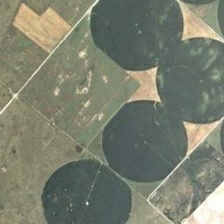
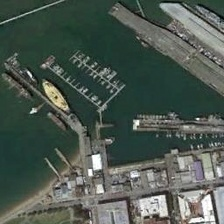
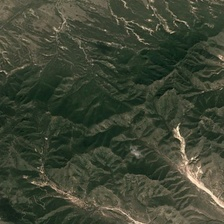
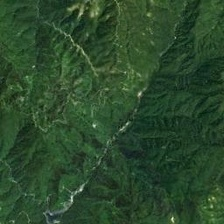

step: 101/201   lr: 0.00000508   loss: 3.7677
step: 102/201   lr: 0.00000500   loss: 3.6479
step: 103/201   lr: 0.00000492   loss: 3.2927
step: 104/201   lr: 0.00000484   loss: 3.7472
step: 105/201   lr: 0.00000476   loss: 3.4337
step: 106/201   lr: 0.00000469   loss: 4.1418
step: 107/201   lr: 0.00000461   loss: 3.8998
step: 108/201   lr: 0.00000453   loss: 3.6660
step: 109/201   lr: 0.00000445   loss: 3.5871
step: 110/201   lr: 0.00000437   loss: 4.0946
step: 111/201   lr: 0.00000430   loss: 3.8095
step: 112/201   lr: 0.00000422   loss: 3.4641
step: 113/201   lr: 0.00000414   loss: 3.3733
step: 114/201   lr: 0.00000406   loss: 3.9577
step: 115/201   lr: 0.00000399   loss: 3.7279
step: 116/201   lr: 0.00000391   loss: 3.9405
step: 117/201   lr: 0.00000383   loss: 3.3334
step: 118/201   lr: 0.00000376   loss: 3.6745
step: 119/201   lr: 0.00000368   loss: 3.7799
step: 120/201   lr: 0.00000361   loss: 3.5662
step: 121/201   lr: 0.00000353   loss: 3.7271
step: 122/201   lr: 0.00000345   l


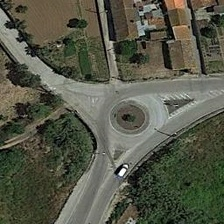
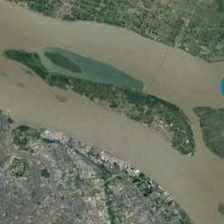
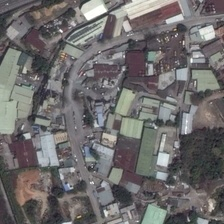
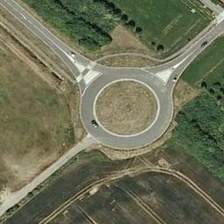

step: 201/201   lr: 0.00000000   loss: 3.8464


eval/bleu,█▁
eval/meteor,█▁
eval/rouge1,█▁
eval/rouge2,▁▁
eval/rougeL,█▁
train/loss,▇███▄▅▇▇▆▇▇▆▂▃▃▄▆▃▄▃▂▄▃▃▄▂▃▂▃▃▂▃▁▂▁▃▃▃▃▂
train/lr,███████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▂▂▂▁▁▁▁▁
eval/bleu,0.00042
eval/meteor,0
eval/rouge1,0
eval/rouge2,0


wandb: Agent Starting Run: c3m2gzi3 with config:
wandb: 	batch_size: 6
wandb: 	learning_rate: 1e-05
wandb: 	lr_decay: cosine
wandb: 	seqlen: 64
wandb: 	warmup_percent: 0.01


step: 1/201   lr: 0.00000500   loss: 5.0289
step: 2/201   lr: 0.00001000   loss: 5.0928
step: 3/201   lr: 0.00001000   loss: 5.0698
step: 4/201   lr: 0.00001000   loss: 5.6622
step: 5/201   lr: 0.00000999   loss: 5.1361
step: 6/201   lr: 0.00000999   loss: 5.5470
step: 7/201   lr: 0.00000998   loss: 4.7192
step: 8/201   lr: 0.00000998   loss: 6.2770
step: 9/201   lr: 0.00000997   loss: 4.9143
step: 10/201   lr: 0.00000996   loss: 5.3802
step: 11/201   lr: 0.00000995   loss: 4.9178
step: 12/201   lr: 0.00000994   loss: 5.2175
step: 13/201   lr: 0.00000993   loss: 4.7971
step: 14/201   lr: 0.00000991   loss: 5.4248
step: 15/201   lr: 0.00000990   loss: 5.0243
step: 16/201   lr: 0.00000988   loss: 5.4642
step: 17/201   lr: 0.00000986   loss: 4.9300
step: 18/201   lr: 0.00000984   loss: 5.1759
step: 19/201   lr: 0.00000982   loss: 5.0364
step: 20/201   lr: 0.00000980   loss: 4.8888
step: 21/201   lr: 0.00000978   loss: 5.4379
step: 22/201   lr: 0.00000976   loss: 5.2798
step: 23/201   lr: 

In [ ]:
wandb.agent(sweep_id, train, count=100)  